# 나의 첫 번째 캐글 경진대회, 무작정 따라해보기
## import & 데이터 load

#### matplotlib 시각화 세팅

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### 필요한 라이브러리 import

In [130]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


#### 데이터 load

In [131]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


## 데이터 확인 및 전처리

#### train 데이터 확인

In [132]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### date 컬럼 전처리

In [133]:
# date를 보기 좋게 앞에서 6자리까지만 나오게 처리한다.

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 학습 데이터 라벨 제거

In [134]:
# price는 라벨(정답)이므로 제거한다.

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### id 컬럼 삭제

In [135]:
# 불필요한 id 컬럼을 삭제한다.

del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### test 데이터 전처리

In [136]:
# test 데이터 역시 train 데이터 처럼 처리한다.

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

test_id = test['id']

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### y 데이터(라벨) 확인

In [137]:
# 라벨 값을 확인

y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

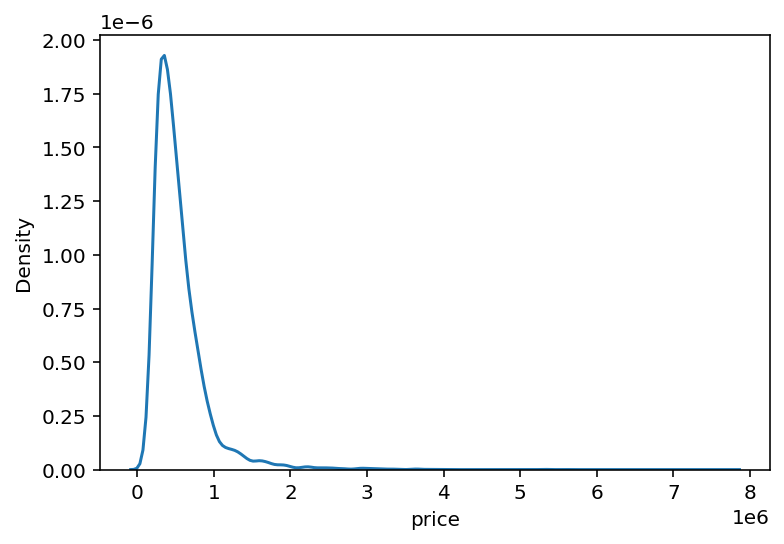

In [138]:
# 라벨 값을 시각화 해 본다. : 한 쪽으로 치우쳐져 있다.

sns.kdeplot(y)
plt.show()

#### y 데이터(라벨) 로그 변환 및 확인

In [139]:
# 치우쳐진 라벨 값을 로그 변환 한다.

y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

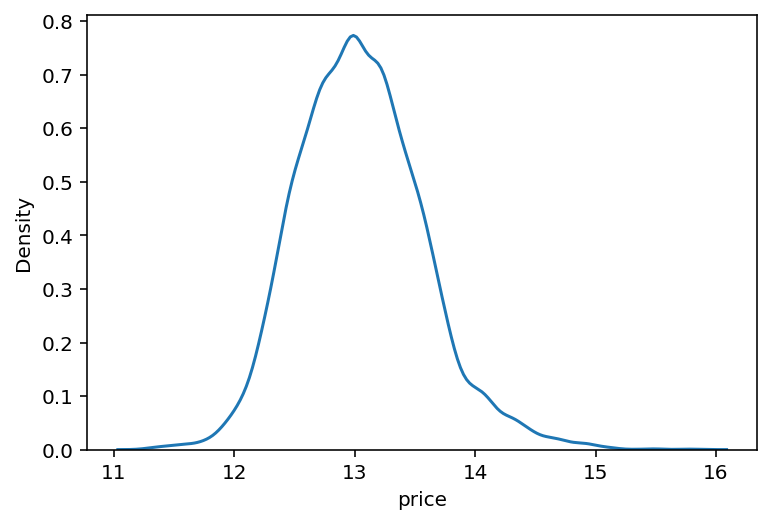

In [140]:
# 로그 변환된 라벨 값을 시각화 한다. : 정규분포에 가깝게 되었다.

sns.kdeplot(y)
plt.show()

#### 전체 데이터 자료형 확인

In [141]:
# 학습 데이터 전체 정보를 살펴본다.

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

### 함수 만들기
#### 필요한 라이브러리 import

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### RMSE 계산 함수 만들기

In [143]:
# 캐글에서 평가지표인 RMSE를 계산하는 함수를 만들어 쓴다.

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#### 모델 불러오기

In [144]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2021

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#### 여러 모델 학습 및 예측 함수 만들기

In [145]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # train, test 데이터셋 분리 - random_state 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

#### 함수 실행

In [146]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,137616.546062
RandomForestRegressor,136497.215502
LGBMRegressor,128291.753330
XGBRegressor,126848.451359


### GridSearchCV로 하이퍼파라미터 튜닝하기 : XGBRegressor
#### GridSearchCV import



In [147]:
from sklearn.model_selection import GridSearchCV

#### GridSearchCV 함수 만들기

In [148]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, 
                              param_grid=param_grid, 
                              scoring='neg_mean_squared_error',
                              cv=5, 
                              verbose=verbose, 
                              n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

#### XGBMRegressor 하이퍼파라미터 찾기

In [149]:
# 파라미터 그리드를 아래와 같이 설정하고 RMSLE값이 가장 낮은 파라미터 조합을 찾는다.

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model2 = XGBRegressor(random_state=random_state)
my_GridSearch(model2, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

,max_depth,n_estimators,score,RMSLE
2,10,50,-0.030349,0.174210
3,10,100,-0.030470,0.174557
1,1,100,-0.043046,0.207475
0,1,50,-0.048745,0.220782


* 가장 좋은 하이퍼파라미터 조합은 max_depth=10, n_estimators=50으로 확인!
#### 모델 학습 및 결과 저장 함수 만들기

In [152]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)  # 로그 값을 원래 값으로 되돌린다.
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    submission['price'] = prediction # 예측값을 price 컬럼에 넣는다.
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    
    print('{} saved!'.format(submission_csv_path))

#### 하이퍼파라미터 튜닝 모델로 결과 예측 및 저장

In [153]:
model2 = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)

save_submission(model2, train, y, test, 'xgb', rmsle='0.0174210')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgb_RMSLE_0.0174210.csv saved!
[CV] END .......................max_depth=1, n_estimators=50; total time=   2.9s
[CV] END ......................max_depth=1, n_estimators=100; total time=   9.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=  49.5s
[CV] END .....................max_depth=10, n_estimators=100; total time= 1.5min
[CV] END .......................max_depth=1, n_estimators=50; total time=   7.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   7.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=  38.0s
[CV] END .....................max_depth=10, n_estimators=100; total time= 1.7min
[CV] END .......................max_depth=1, n_estimators=50; total time=   3.3s
[CV] END ......................max_depth=1, n_estimators=100; total time=  10.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=  45.0s
[CV] END ..................

#### 결과 제출 및 점수 확인
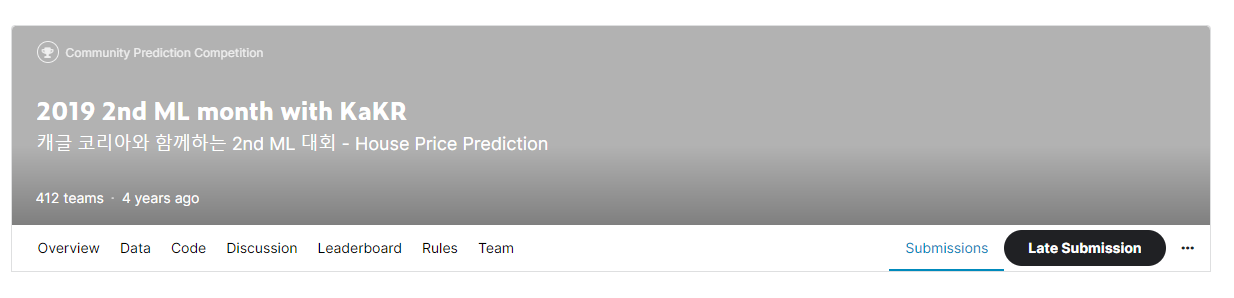
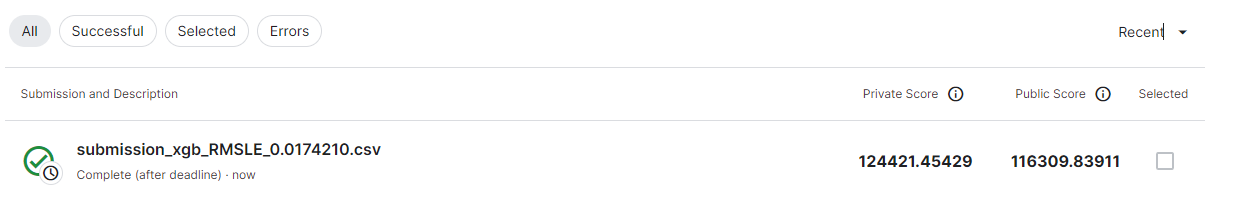

### 결과
* Private Score : 124421.45429
* Public Score : 116309.83911

점수를 더 낮춰야한다..

### 하이퍼파라미터 튜닝하기 : GradientBoostingRegressor
#### GradientBoostingRegressor 하이퍼파라미터 찾기

In [154]:
# 파라미터 그리드를 아래와 같이 설정하고 RMSLE값이 가장 낮은 파라미터 조합을 찾는다.

param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [1, 5, 10],
    'learning_rate': [0.001, 0.01, 0.1]
}

model3 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model3, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
23,0.100,5,100,-0.028579,0.169052
22,0.100,5,75,-0.029570,0.171958
26,0.100,10,100,-0.029578,0.171983
25,0.100,10,75,-0.029644,0.172173
24,0.100,10,50,-0.030023,0.173273
21,0.100,5,50,-0.031356,0.177076
20,0.100,1,100,-0.055036,0.234597
19,0.100,1,75,-0.061509,0.248010
17,0.010,10,100,-0.068830,0.262354
18,0.100,1,50,-0.073253,0.270653


* 가장 좋은 하이퍼파라미터 조합은 learning_rate=0.1, max_depth=5, n_estimators=100으로 확인!
#### 하이퍼파라미터 튜닝 모델로 결과 예측 및 저장

In [155]:
model3 = GradientBoostingRegressor(max_depth=5, n_estimators=100, learning_rate=0.1, random_state=random_state)

save_submission(model3, train, y, test, 'gb', rmsle='0.169052')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_gb_RMSLE_0.169052.csv saved!
[CV] END ..learning_rate=0.001, max_depth=1, n_estimators=50; total time=   2.5s
[CV] END ..learning_rate=0.001, max_depth=1, n_estimators=75; total time=   3.8s
[CV] END .learning_rate=0.001, max_depth=1, n_estimators=100; total time=   6.0s
[CV] END ..learning_rate=0.001, max_depth=5, n_estimators=50; total time=  11.8s
[CV] END ..learning_rate=0.001, max_depth=5, n_estimators=75; total time=  19.2s
[CV] END .learning_rate=0.001, max_depth=5, n_estimators=100; total time=  25.3s
[CV] END .learning_rate=0.001, max_depth=10, n_estimators=50; total time=  25.6s
[CV] END .learning_rate=0.001, max_depth=10, n_estimators=75; total time=  38.5s
[CV] END learning_rate=0.001, max_depth=10, n_estimators=100; total time=  52.6s
[CV] END ...learning_rate=0.01, max_depth=1, n_estimators=75; total time=   4.8s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   5.2s
[CV] END ...learning_rate=0.0

#### 결과 제출 / 점수 확인
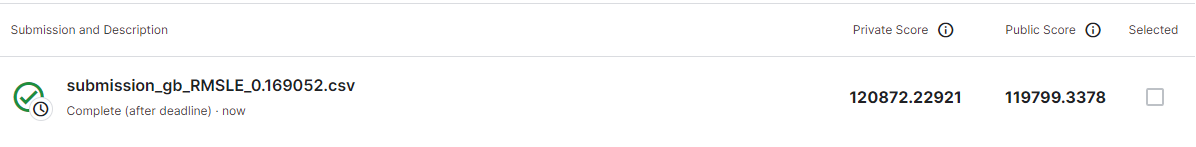

* 점수는 119799점으로 더 안좋아 졌다.   
다른 방법으로 낮춰보자

#### LGBRegressor   
LGBMRegressor 하이퍼파라미터 찾기

In [156]:
# 파라미터 그리드를 아래와 같이 설정하고 RMSLE값이 가장 낮은 파라미터 조합을 찾는다.

param_grid = {
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
62,0.1000,20,300,-0.026091,0.161527
55,0.1000,10,400,-0.026121,0.161619
54,0.1000,10,300,-0.026127,0.161640
53,0.1000,10,200,-0.026188,0.161828
63,0.1000,20,400,-0.026206,0.161883
...,...,...,...,...,...
1,0.0001,5,200,-0.270236,0.519842
8,0.0001,15,100,-0.274318,0.523753
12,0.0001,20,100,-0.274318,0.523753
4,0.0001,10,100,-0.274318,0.523753


* 가장 좋은 하이퍼파라미터 조합은 learning_rate=0.1, max_depth=20, n_estimators=300으로 확인!

#### 하이퍼파라미터 튜닝 모델로 결과 예측 및 저장

In [157]:
model = LGBMRegressor(learning_rate=0.1, max_depth=20, n_estimators=300, random_state=random_state)

save_submission(model, train, y, test, 'lgbm', rmsle='0.161527')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161527.csv saved!
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=100; total time=   1.6s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=200; total time=   2.8s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=300; total time=   4.3s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=400; total time=   6.0s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=100; total time=   1.8s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=200; total time=   3.2s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=300; total time=   5.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=400; total time=   8.3s
[CV] END learning_rate=0.0001, max_depth=15, n_estimators=100; total time=   2.0s
[CV] END learning_rate=0.0001, max_depth=15, n_estimators=200; total time=   3.7s
[CV] END learning_rate=0.0001, max_depth=15, n_estimators=300; total time=   5.9s
[CV] END learning_ra

#### 결과 제출 / 점수 확인
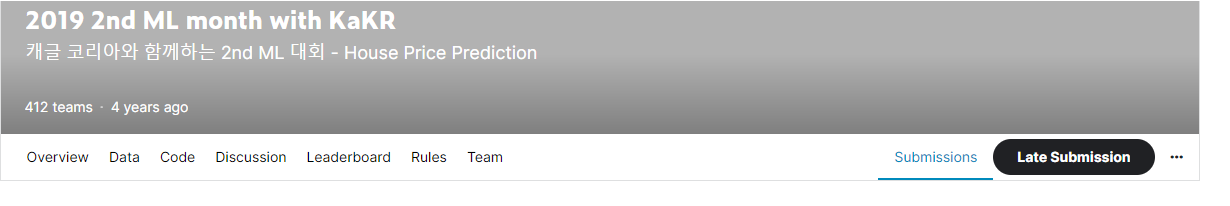
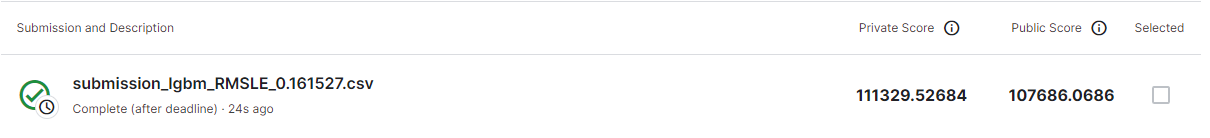

* 점수는 드디어 11만점 이하인 1107686.0686점 이다.

## 회고?
캐글에서 좋은 성능을 내는 것도 크게 어렵지 않을 것이라고 생각했는데 잘못 생각한것 같다. 조금 어려웠다..내가 아직 모르는게 많구나..ㅠ

아직 모델 자체와 모델별 하이퍼파라미터에 대한 이해가 많이 부족하다. 다양한 모델들과 하이퍼파라미터에 대해 시간을 갖고 하나 하나 살펴봐야겠다고 생각이 든다